# Predicting Credit Risk for Loan Applicants

**Dataset:** [German Credit dataset (Kaggle)](https://www.kaggle.com/datasets/uciml/german-credit)

---

## 1. Problem Statement  
Financial institutions face significant challenges in assessing the creditworthiness of loan applicants. The goal of this project is to build a model that classifies each applicant as either a **good credit risk** or a **bad credit risk**, minimizing defaults and helping lenders make informed decisions.

---

## 2. Background  
The German Credit dataset contains 1,000 records with 20 attributes covering applicants’ financial history, personal information, and loan details. It’s widely used for benchmarking classification algorithms in credit-scoring research.

---

## 3. Objective  
- **Primary:** Develop a machine learning classifier to predict credit risk (good vs. bad).  
- **Secondary:**  
  - Identify and interpret the most influential features.  
  - Propose actionable strategies to enhance the credit evaluation process.

---

In [75]:
%pip install Jinja2

  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached MarkupSafe-3.0.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (4.0 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached MarkupSafe-3.0.2-cp312-cp312-macosx_11_0_arm64.whl (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [Jinja2]
Note: you may need to restart the kernel to use updated packages.


In [32]:
# Import Block
import warnings 
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.tools as tls
import plotly.offline as py 
import plotly.express as px
import plotly.graph_objs as go 
from collections import Counter 
import matplotlib.pyplot as plt 
from plotly.subplots import make_subplots

### Custom Theme & Config

In [27]:
# Display Max columns
pd.pandas.set_option("display.max_columns", None)

# enable offline plotly version
py.init_notebook_mode(connected=True) 

# Dark Mode of Ploty
pio.templates.default = "plotly_dark"

# Dark Mode
sns.set_theme(
    style='dark',
    rc={
        'figure.facecolor': 'black',
        'axes.facecolor':   'black',
        'axes.edgecolor':   'white',
        'savefig.facecolor':'black',
        'text.color':       'white',
        'axes.labelcolor':  'white',
        'xtick.color':      'white',
        'ytick.color':      'white' 
    }
)

plt.rcParams.update({
    'figure.facecolor': 'black',
    'axes.facecolor':   'black',
    'axes.edgecolor':   'white',
    'savefig.facecolor':'black',
    'text.color':       'white',
    'axes.labelcolor':  'white',
    'xtick.color':      'white',
    'ytick.color':      'white',
    'grid.color':       'gray',
})

In [3]:
df = pd.read_csv("../data/raw/german_credit_data.csv")

## 1. **Data Overview**
A foundational understanding of the dataset.
- Dimensions of the dataset
- Data types and null counts for each column
- Number of unique values per column
- Basic statistical summary of numeric features
- Preview of the first few rows of the dataset

In [80]:
# ------------------------------------------------------------
# 1. Data Overview
#    Provide a dimensional understanding of the dataset
# ------------------------------------------------------------
print("_" * 120)
print(f"DIMENSIONS OF DATASET: {df.shape}")  # rows and columns
print("_" * 120)


# ------------------------------------------------------------
# 2. Feature Information
#    Display data types and non-null counts for each column
# ------------------------------------------------------------
print("FEATURE INFO:")
df.info()
print("_" * 120)


# ------------------------------------------------------------
# 3. Unique Value Counts
#    Show number of distinct entries per column
# ------------------------------------------------------------
print("UNIQUE VALUE COUNTS:")
print(df.nunique())
print("_" * 120)


# ------------------------------------------------------------
# 4. Basic Statistical Summary
#    Summary of numeric columns (mean, std, min, max, etc.)
# ------------------------------------------------------------
print("BASIC STATISTICS:")
print(df.describe())
print("_" * 120)


# ------------------------------------------------------------
# 5. Categorical Value Counts
#    Frequency counts for all object-dtype (categorical) columns
# ------------------------------------------------------------
print("CATEGORICAL VALUE COUNTS:")
cat_cols = [col for col in df.columns if df[col].dtype == 'O']
for col in cat_cols:
    print(f"\n-- {col} --")
    print(df[col].value_counts())
print("_" * 120)


# ------------------------------------------------------------
# 6. Sample of Data
#    Preview the first few rows of the dataset
# ------------------------------------------------------------
print("DATA PREVIEW:")
print(df.head())
print("_" * 120)


________________________________________________________________________________________________________________________
DIMENSIONS OF DATASET: (1000, 12)
________________________________________________________________________________________________________________________
FEATURE INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Unnamed: 0        1000 non-null   int64   
 1   Age               1000 non-null   int64   
 2   Sex               1000 non-null   object  
 3   Job               1000 non-null   int64   
 4   Housing           1000 non-null   object  
 5   Saving accounts   817 non-null    object  
 6   Checking account  606 non-null    object  
 7   Credit amount     1000 non-null   int64   
 8   Duration          1000 non-null   int64   
 9   Purpose           1000 non-null   object  
 10  Risk              1000 

`The dataset contains 1,000 entries with various features like **Age**, **Sex**, **Job**, and the target variable **Risk** (good/bad credit risk).`

### **EDA (Exploratory of Data Analysis)**
- Starting by distribuition of column Age.

In [ ]:
trace0 = go.Bar(
            x = df[df["Risk"]== 'good']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'good']["Risk"].value_counts().values,
            name='Good credit',
            marker_color="greenyellow"
    )

trace1 = go.Bar(
            x = df[df["Risk"]== 'bad']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'bad']["Risk"].value_counts().values,
            name='Bad credit',
            marker_color="crimson"
    )

data = [trace0, trace1]

layout = go.Layout()

layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='Risk'
    ),
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')

Distribution plot highlights a class imbalance in the target variable

___

In [ ]:
# 1. Identify numerical columns (excluding any “Unnamed: 0” column)
num_cols = [
    col 
    for col in df.columns 
    if df[col].dtype != 'O' and col != 'Unnamed: 0'
]
print('Number of numerical variables:', len(num_cols))

# 2a. Using Plotly Express histograms
for col in num_cols:
    fig = px.histogram(
        df,
        x=col,
        nbins=50,
        title=f'Histogram of {col}',
        opacity=0.6,
        color_discrete_sequence=['mediumpurple']
    )
    fig.update_layout(
        xaxis_title=col,
        yaxis_title='Count'
    )
    py.offline.iplot(fig)

Number of numerical variables: 4


In [35]:
# Prepare age distributions
df_good = df.loc[df["Risk"] == 'good', 'Age']
df_bad  = df.loc[df["Risk"] == 'bad',  'Age']
df_age  = df['Age']

# Histogram traces
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

# Create subplots: 2 rows, 2 cols, with bottom row spanned
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}], [{'colspan': 2}, None]],
    subplot_titles=('Good', 'Bad', 'General Distribution')
)

# Add traces to subplots
fig.add_trace(trace0, row=1, col=1)
fig.add_trace(trace1, row=1, col=2)
fig.add_trace(trace2, row=2, col=1)

# Update layout
fig.update_layout(
    showlegend=True,
    title='Age Distribution',
    bargap=0.05
)

fig.show()

<h2>Creating an categorical variable to handle with the Age variable </h2>

In [38]:
#Let's look the Credit Amount column
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)


df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

In [39]:
trace0 = go.Box(
    y=df_good["Credit amount"],
    x=df_good["Age_cat"],
    name='Good credit',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=df_bad['Credit amount'],
    x=df_bad['Age_cat'],
    name='Bad credit',
    marker=dict(
        color='#FF4136'
    )
)

data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount (US Dollar)',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

Todo: add the insights

<h2>I will now Look the distribuition of Housing own and rent by Risk</h2>


In [41]:
#First plot
trace0 = go.Bar(
    x = df[df["Risk"]== 'good']["Housing"].value_counts().index.values,
    y = df[df["Risk"]== 'good']["Housing"].value_counts().values,
    name='Good credit',
    marker_color="greenyellow"
)

#Second plot
trace1 = go.Bar(
    x = df[df["Risk"]== 'bad']["Housing"].value_counts().index.values,
    y = df[df["Risk"]== 'bad']["Housing"].value_counts().values,
    name="Bad Credit",
    marker_color="crimson"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Housing Distribuition'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Housing-Grouped')

we can see that the own and good risk have a high correlation

<h3>Distribuition of Credit Amount by Housing</h3>

In [44]:
fig = {
    "data": [
        {
            "type": 'violin',
            "x": df_good['Housing'],
            "y": df_good['Credit amount'],
            "legendgroup": 'Good Credit',
            "scalegroup": 'No',
            "name": 'Good Credit',
            "side": 'negative',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            },
            "line": {
                "color": 'blue'
            }
        },
        {
            "type": 'violin',
            "x": df_bad['Housing'],
            "y": df_bad['Credit amount'],
            "legendgroup": 'Bad Credit',
            "scalegroup": 'No',
            "name": 'Bad Credit',
            "side": 'positive',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            },
            "line": {
                "color": 'green'
            }
        }
    ],
    "layout" : {
        "yaxis": {
            "zeroline": False,
        },
        "violingap": 0,
        "violinmode": "overlay",
        "paper_bgcolor": "black",
        "plot_bgcolor": "black"
    }
}


py.iplot(fig, filename = 'violin/split', validate = False)

Interesting moviments! Highest values come from category "free" and we have a different distribuition by Risk

<h2>Looking the diference by Sex</h2>

In [47]:
# Traces
trace0 = go.Bar(
    x=df[df["Risk"]=='good']["Sex"].value_counts().index,
    y=df[df["Risk"]=='good']["Sex"].value_counts().values,
    name='Good credit'
)
trace1 = go.Bar(
    x=df[df["Risk"]=='bad']["Sex"].value_counts().index,
    y=df[df["Risk"]=='bad']["Sex"].value_counts().values,
    name='Bad Credit'
)
trace2 = go.Box(
    x=df[df["Risk"]=='good']["Sex"],
    y=df[df["Risk"]=='good']["Credit amount"],
    name='Good credit'
)
trace3 = go.Box(
    x=df[df["Risk"]=='bad']["Sex"],
    y=df[df["Risk"]=='bad']["Credit amount"],
    name='Bad Credit'
)

# Create figure with two columns
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Sex Count', 'Credit Amount by Sex')
)

# Add traces
fig.add_trace(trace0, row=1, col=1)
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.add_trace(trace3, row=1, col=2)

# Update layout
fig.update_layout(
    title='Sex Distribution',
    boxmode='group',
)

# Update axes styling to stand out on dark bg
fig.update_xaxes(showgrid=False, row=1, col=1)
fig.update_xaxes(showgrid=False, row=1, col=2)
fig.update_yaxes(gridcolor='grey', zerolinecolor='grey')

fig.show()


In [49]:
#First plot
trace0 = go.Bar(
    x = df[df["Risk"]== 'good']["Job"].value_counts().index.values,
    y = df[df["Risk"]== 'good']["Job"].value_counts().values,
    name='Good credit Distribuition',
    marker_color="greenyellow"
)

#Second plot
trace1 = go.Bar(
    x = df[df["Risk"]== 'bad']["Job"].value_counts().index.values,
    y = df[df["Risk"]== 'bad']["Job"].value_counts().values,
    name="Bad Credit Distribuition",
    marker_color="crimson"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Job Distribuition'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')

In [51]:
trace0 = go.Box(
    x=df_good["Job"],
    y=df_good["Credit amount"],
    name='Good credit',
    marker_color="greenyellow"
)

trace1 = go.Box(
    x=df_bad['Job'],
    y=df_bad['Credit amount'],
    name='Bad credit',
    marker_color="crimson"
)

data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount distribuition by Job'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

In [53]:

fig = {
    "data": [
        {
            "type": 'violin',
            "x": df_good['Job'],
            "y": df_good['Age'],
            "legendgroup": 'Good Credit',
            "scalegroup": 'No',
            "name": 'Good Credit',
            "side": 'negative',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            },
            "line": {
                "color": 'blue'
            }
        },
        {
            "type": 'violin',
            "x": df_bad['Job'],
            "y": df_bad['Age'],
            "legendgroup": 'Bad Credit',
            "scalegroup": 'No',
            "name": 'Bad Credit',
            "side": 'positive',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            },
            "line": {
                "color": 'green'
            }
        }
    ],
    "layout" : {
        "yaxis": {
            "zeroline": False,
        },
        "violingap": 0,
        "violinmode": "overlay",
        "paper_bgcolor": "black",
        "plot_bgcolor": "black"
    }
}


py.iplot(fig, filename = 'Age-Housing', validate = False)

In [57]:
import plotly.figure_factory as ff

import numpy as np

# Add histogram data
x1 = np.log(df_good['Credit amount']) 
x2 = np.log(df_bad["Credit amount"])

# Group data together
hist_data = [x1, x2]

group_labels = ['Good Credit', 'Bad Credit']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2)

# Plot!
py.iplot(fig, filename='Distplot with Multiple Datasets')

In [89]:
from plotly import tools
import numpy as np
import plotly.graph_objs as go

count_good = go.Bar(
    x = df_good["Saving accounts"].value_counts().index.values,
    y = df_good["Saving accounts"].value_counts().values,
    name='Good credit'
)
count_bad = go.Bar(
    x = df_bad["Saving accounts"].value_counts().index.values,
    y = df_bad["Saving accounts"].value_counts().values,
    name='Bad credit'
)


box_1 = go.Box(
    x=df_good["Saving accounts"],
    y=df_good["Credit amount"],
    name='Good credit'
)
box_2 = go.Box(
    x=df_bad["Saving accounts"],
    y=df_bad["Credit amount"],
    name='Bad credit'
)

scat_1 = go.Box(
    x=df_good["Saving accounts"],
    y=df_good["Age"],
    name='Good credit'
)
scat_2 = go.Box(
    x=df_bad["Saving accounts"],
    y=df_bad["Age"],
    name='Bad credit'
)

data = [scat_1, scat_2, box_1, box_2, count_good, count_bad]

fig = tools.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Count Saving Accounts','Credit Amount by Savings Acc', 
                                          'Age by Saving accounts'))

fig.append_trace(count_good, 1, 1)
fig.append_trace(count_bad, 1, 1)

fig.append_trace(box_2, 1, 2)
fig.append_trace(box_1, 1, 2)

fig.append_trace(scat_1, 2, 1)
fig.append_trace(scat_2, 2, 1)



fig['layout'].update(height=700, width=800, title='Saving Accounts Exploration', boxmode='group')

py.iplot(fig, filename='combined-savings')


/Users/nex/repos/ml-projects/credit_risk_prediction/.venv/lib/python3.12/site-packages/plotly/tools.py:453: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [66]:
# Prepare traces
count_good = go.Bar(
    x=df_good["Saving accounts"].value_counts().index,
    y=df_good["Saving accounts"].value_counts().values,
    name='Good credit'
)
count_bad = go.Bar(
    x=df_bad["Saving accounts"].value_counts().index,
    y=df_bad["Saving accounts"].value_counts().values,
    name='Bad credit'
)
box_1 = go.Box(
    x=df_good["Saving accounts"],
    y=df_good["Credit amount"],
    name='Good credit'
)
box_2 = go.Box(
    x=df_bad["Saving accounts"],
    y=df_bad["Credit amount"],
    name='Bad credit'
)
scat_1 = go.Box(
    x=df_good["Saving accounts"],
    y=df_good["Age"],
    name='Good credit'
)
scat_2 = go.Box(
    x=df_bad["Saving accounts"],
    y=df_bad["Age"],
    name='Bad credit'
)

# Create subplots: 2 rows, 2 cols, bottom row spans both columns
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}], [{'colspan': 2}, None]],
    subplot_titles=(
        'Count Saving Accounts',
        'Credit Amount by Saving Account',
        'Age by Saving Account'
    )
)

# Add trace groups to subplots
fig.add_trace(count_good, row=1, col=1)
fig.add_trace(count_bad, row=1, col=1)

fig.add_trace(box_1, row=1, col=2)
fig.add_trace(box_2, row=1, col=2)

fig.add_trace(scat_1, row=2, col=1)
fig.add_trace(scat_2, row=2, col=1)

# Layout updates
fig.update_layout(
  height= 700,
    title='Saving Accounts Exploration',
    boxmode='group'
)

fig.show()


In [67]:
#First plot
trace0 = go.Bar(
    x = df[df["Risk"]== 'good']["Checking account"].value_counts().index.values,
    y = df[df["Risk"]== 'good']["Checking account"].value_counts().values,
    name='Good credit Distribuition' 
    
)

#Second plot
trace1 = go.Bar(
    x = df[df["Risk"]== 'bad']["Checking account"].value_counts().index.values,
    y = df[df["Risk"]== 'bad']["Checking account"].value_counts().values,
    name="Bad Credit Distribuition"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Checking accounts Distribuition',
    xaxis=dict(title='Checking accounts name'),
    yaxis=dict(title='Count'),
    barmode='group'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename = 'Age-ba', validate = False)

In [68]:
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

trace0 = go.Box(
    y=df_good["Credit amount"],
    x=df_good["Checking account"],
    name='Good credit',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=df_bad['Credit amount'],
    x=df_bad['Checking account'],
    name='Bad credit',
    marker=dict(
        color='#FF4136'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Cheking distribuition'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

In [70]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Display missing value distribution
print("Total values of the most missing variable: ")
print(df.groupby("Checking account")["Checking account"].count())

# Create subplots layout: 2 rows, 2 columns, with bottom row spanning
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{}, {}], [{'colspan': 2}, None]],
    subplot_titles=[
        "Checking Account Count by Risk",
        "Age by Checking Account",
        "Credit Amount by Checking Account"
    ]
)

# --- Plot 1: Countplot ---
for risk_value in df["Risk"].unique():
    subset = df[df["Risk"] == risk_value]["Checking account"].value_counts().sort_index()
    fig.add_trace(
        go.Bar(
            x=subset.index,
            y=subset.values,
            name=f"{risk_value} Credit"
        ),
        row=1, col=1
    )

# --- Plot 2: Violin plot of Age ---
for risk_value, side, color in zip(df["Risk"].unique(), ['negative', 'positive'], ['blue', 'orange']):
    fig.add_trace(
        go.Violin(
            x=df[df["Risk"] == risk_value]["Checking account"],
            y=df[df["Risk"] == risk_value]["Age"],
            name=f"{risk_value} Credit",
            side=side,
            box={"visible": True},
            meanline={"visible": True},
            line_color=color,
            showlegend=False
        ),
        row=1, col=2
    )

# --- Plot 3: Box plot of Credit amount ---
for risk_value, color in zip(df["Risk"].unique(), ['blue', 'orange']):
    fig.add_trace(
        go.Box(
            x=df[df["Risk"] == risk_value]["Checking account"],
            y=df[df["Risk"] == risk_value]["Credit amount"],
            name=f"{risk_value} Credit",
            marker_color=color
        ),
        row=2, col=1
    )

# Layout styling
fig.update_layout(
    height=800,
    title_text="Exploration of Checking Account Feature",
    boxmode='group',
    violingap=0,
    violinmode="overlay"
)

fig.show()


Total values of the most missing variable: 
Checking account
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64


In [73]:
# Create the figure
fig = go.Figure()

# Define sides and colors for mirroring the split violin plot
sides = ['negative', 'positive']
colors = ['blue', 'orange']  # Or use your preferred palette
risks = df["Risk"].unique()

# Add one violin trace per risk category
for side, color, risk in zip(sides, colors, risks):
    fig.add_trace(go.Violin(
        x=df[df["Risk"] == risk]["Housing"],
        y=df[df["Risk"] == risk]["Job"],
        name=f"{risk} Credit",
        side=side,
        box=dict(visible=True),
        meanline=dict(visible=True),
        line_color=color,
        points=False,
        spanmode='hard'
    ))

# Update layout
fig.update_layout(
    title="Housing x Job - Dist",
    xaxis_title="Housing",
    yaxis_title="Job",
    width=900,
    height=1000,
    violingap=0,
    violinmode="overlay"
)

fig.show()

In [76]:
date_int = ["Purpose", 'Sex']
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(df[date_int[0]], df[date_int[1]]).style.background_gradient(cmap = cm)

Sex,female,male
Purpose,,
business,19,78
car,94,243
domestic appliances,6,6
education,24,35
furniture/equipment,74,107
radio/TV,85,195
repairs,5,17
vacation/others,3,9


## Looking the total of values in each categorical feature


In [78]:
print("Purpose : ",df.Purpose.unique())
print("Sex : ",df.Sex.unique())
print("Housing : ",df.Housing.unique())
print("Saving accounts : ",df['Saving accounts'].unique())
print("Risk : ",df['Risk'].unique())
print("Checking account : ",df['Checking account'].unique())
print("Aget_cat : ",df['Age_cat'].unique())

Purpose :  ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
Sex :  ['male' 'female']
Housing :  ['own' 'free' 'rent']
Saving accounts :  [nan 'little' 'quite rich' 'rich' 'moderate']
Risk :  ['good' 'bad']
Checking account :  ['little' 'moderate' nan 'rich']
Aget_cat :  ['Senior', 'Student', 'Adult', 'Young']
Categories (4, object): ['Student' < 'Young' < 'Adult' < 'Senior']


In [81]:
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, drop_first=True)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [82]:
df['Saving accounts'] = df['Saving accounts'].fillna('no_inf')
df['Checking account'] = df['Checking account'].fillna('no_inf')

#Purpose to Dummies Variable
df = df.merge(pd.get_dummies(df.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
#Sex feature in dummies
df = df.merge(pd.get_dummies(df.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)
# Housing get dummies
df = df.merge(pd.get_dummies(df.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
# Housing get Saving Accounts
df = df.merge(pd.get_dummies(df["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
# Housing get Risk
df = df.merge(pd.get_dummies(df.Risk, prefix='Risk'), left_index=True, right_index=True)
# Housing get Checking Account
df = df.merge(pd.get_dummies(df["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
# Housing get Age categorical
df = df.merge(pd.get_dummies(df["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)

In [83]:
#Excluding the missing columns
del df["Saving accounts"]
del df["Checking account"]
del df["Purpose"]
del df["Sex"]
del df["Housing"]
del df["Age_cat"]
del df["Risk"]
del df['Risk_good']

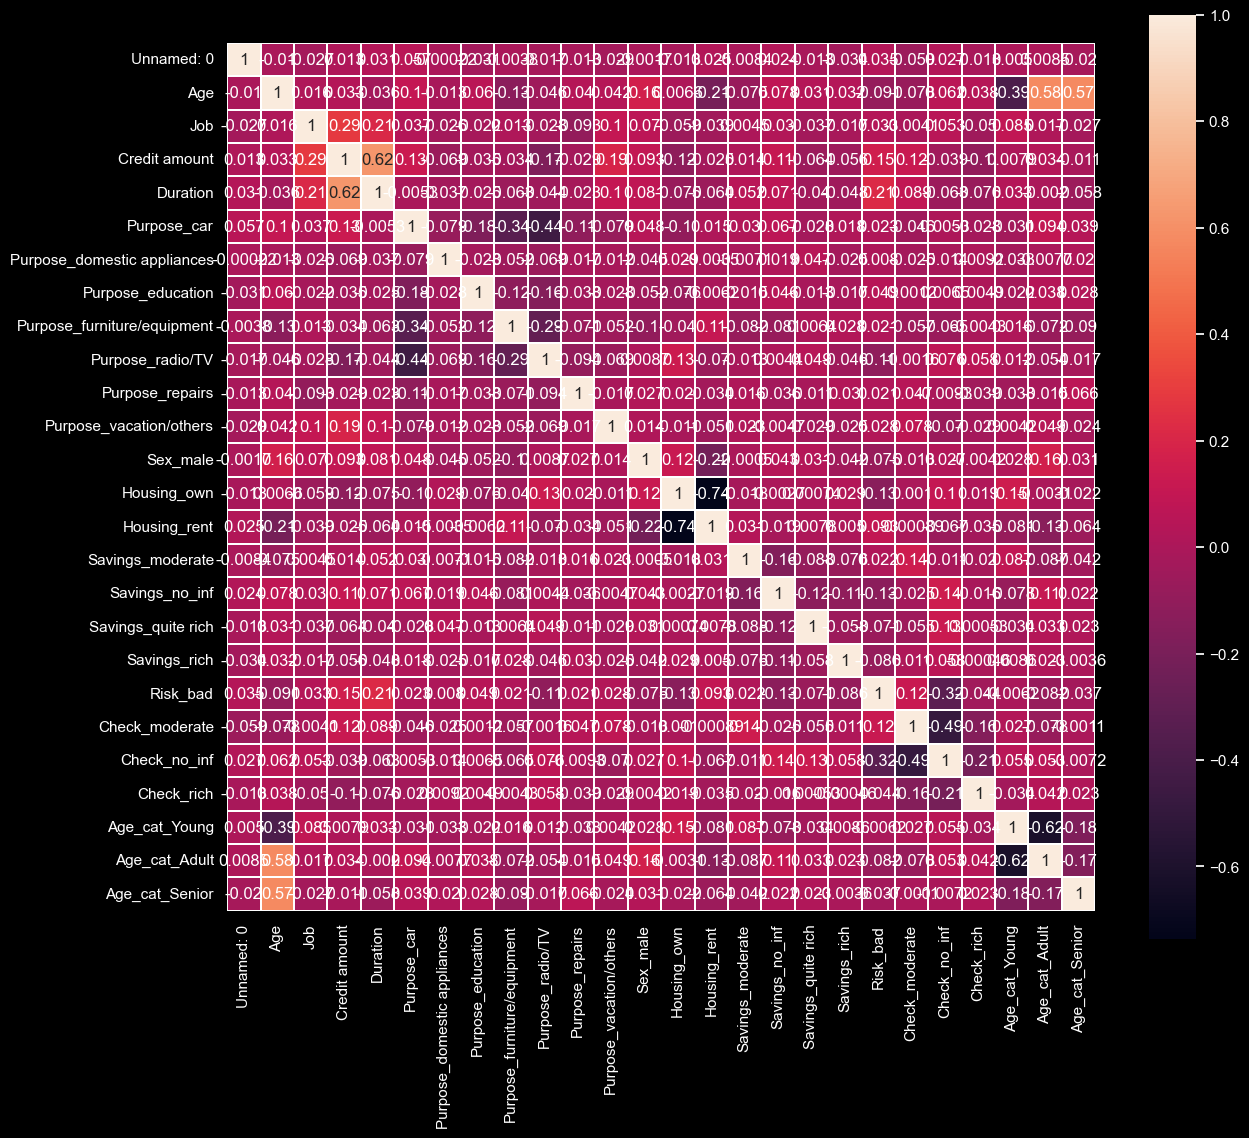

In [85]:
plt.figure(figsize=(14,12))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

In [86]:
df['Credit amount'] = np.log(df['Credit amount'])

0      False
1       True
2      False
3      False
4       True
       ...  
995    False
996    False
997    False
998     True
999    False
Name: Risk_bad, Length: 1000, dtype: bool

In [5]:
print(f"_______________ Missing Values: _______________\n{df.isnull().sum()}")

_______________ Missing Values: _______________
Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


<Axes: >

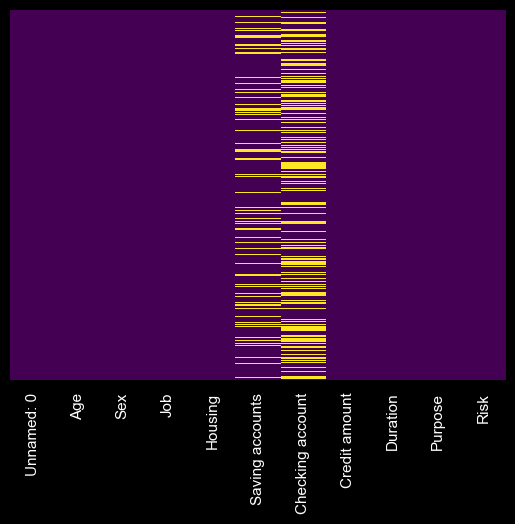

In [6]:
# Heatmap of dataframe's missing value mask
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')